# Link Prediction with NASA GES-DISC Dataset

## Data preperation for GNN

In [1]:
import pandas as pd
import ast

In [2]:
nodes_df = pd.read_csv('./Data/nodes.csv')
edges_df = pd.read_csv('./Data/train_edges.csv')


In [3]:
nodes_df['properties'] = nodes_df['properties'].apply(ast.literal_eval)

In [4]:
nodes_df['label'] = nodes_df['label'].apply(lambda x: ast.literal_eval(x)[0])

In [5]:
print(nodes_df['properties'][0]['abstract'])

The Atmospheric Infrared Sounder (AIRS) is a grating spectrometer (R = 1200) aboard the second Earth Observing System (EOS) polar-orbiting platform, EOS Aqua. In combination with the Advanced Microwave Sounding Unit (AMSU) and the Humidity Sounder for Brazil (HSB), AIRS constitutes an innovative atmospheric sounding group of visible, infrared, and microwave sensors. The L3 support products are similar to the L3 standard products but contain fields which are not fully validated, or are inputs or intermediary values. Because no quality control information is available for some of these fields, values from failed retrievals may be included.


### Generating User generated abstarcts based on the Label of the node, Will be used later to create user embeddings

In [6]:
def generate_abstract(row):
    abst=''
    if row['label'] == 'Dataset':
        # Extract 'doi' if present
        st = row['properties'].get('shortName', None)  # Use .get() to avoid KeyError if 'doi' does not exist
        desc = row['properties'].get('abstract', None)
        abst = 'The following Node is a dataset named: '+st+'. Description: ' +desc
        
    
    elif row['label'] == 'Publication':
        Title = row['properties'].get('Title', 'No Name available')
        abst = 'The following Node is a Publication Titled: '+Title+'.'
        

    elif row['label'] == 'DataCenter':
        Title = row['properties'].get('longName', None)
        abst = 'The following Node is a Data Center Titled: '+Title+'.'

    elif row['label'] == 'Platform':
        Title = row['properties'].get('longName', None)
        abst = 'The following Node is a Platform Titled: '+Title+'.'

    elif row['label'] == 'ScienceKeyword':
        Title = row['properties'].get('name', None)
        abst = 'The following Node is a Science Keyword: '+Title+'.'

    elif row['label'] == 'Project':
        Title = row['properties'].get('longName', None)
        abst = 'The following Node is a Project Titled: '+Title+'.'

    elif row['label'] == 'Instrument':
        Title = row['properties'].get('longName', None)
        abst = 'The following Node is a Instrument Titled: '+Title+'.'
        
    row['abstract']=abst
    return row

In [7]:
def generate_abstract_short(row):
    abst=''
    if row['label'] == 'Dataset':
        # Extract 'doi' if present
        st = row['properties'].get('shortName', None)  # Use .get() to avoid KeyError if 'doi' does not exist
        abst = 'The following Node is a dataset named: '+st+'. Description: '
        
    
    elif row['label'] == 'Publication':
        Title = row['properties'].get('Title', 'No Name available')
        abst = 'The following Node is a Publication Titled: '+Title+'.'
        

    elif row['label'] == 'DataCenter':
        Title = row['properties'].get('longName', None)
        abst = 'The following Node is a Data Center Titled: '+Title+'.'

    elif row['label'] == 'Platform':
        Title = row['properties'].get('longName', None)
        abst = 'The following Node is a Platform Titled: '+Title+'.'

    elif row['label'] == 'ScienceKeyword':
        Title = row['properties'].get('name', None)
        abst = 'The following Node is a Science Keyword: '+Title+'.'

    elif row['label'] == 'Project':
        Title = row['properties'].get('longName', None)
        abst = 'The following Node is a Project Titled: '+Title+'.'

    elif row['label'] == 'Instrument':
        Title = row['properties'].get('longName', None)
        abst = 'The following Node is a Instrument Titled: '+Title+'.'
        
    row['abstract_short']=abst
    return row

In [8]:
nodes_df['abstract']=None
nodes_df['abstract_short']=None
nodes_df = nodes_df.apply(generate_abstract, axis=1)
nodes_df = nodes_df.apply(generate_abstract_short, axis=1)

In [9]:
nodes_df

,id,label,properties,abstract,abstract_short
0,0,Dataset,{'abstract': 'The Atmospheric Infrared Sounder...,The following Node is a dataset named: AIRS3SP...,The following Node is a dataset named: AIRS3SP...
1,1,Dataset,{'abstract': 'Version 07 is the current versio...,The following Node is a dataset named: GPM_3GP...,The following Node is a dataset named: GPM_3GP...
2,2,Dataset,{'abstract': 'The Solar Backscattered Ultravio...,The following Node is a dataset named: SBUV2N1...,The following Node is a dataset named: SBUV2N1...
3,3,Dataset,{'abstract': 'The data presented in this level...,The following Node is a dataset named: PRECIP_...,The following Node is a dataset named: PRECIP_...
4,4,Dataset,{'abstract': 'The TROPESS CrIS-SNPP L2 for Sao...,The following Node is a dataset named: TRPSDL2...,The following Node is a dataset named: TRPSDL2...
...,...,...,...,...,...
5758,25019,ScienceKeyword,"{'name': 'WATER ION CONCENTRATIONS', 'globalId...",The following Node is a Science Keyword: WATER...,The following Node is a Science Keyword: WATER...
5759,25020,ScienceKeyword,"{'name': 'WATER TRACE ELEMENTS', 'globalId': '...",The following Node is a Science Keyword: WATER...,The following Node is a Science Keyword: WATER...
5760,25021,ScienceKeyword,"{'name': 'pH', 'globalId': 'd2cbb2ca-aaa2-54f1...",The following Node is a Science Keyword: pH.,The following Node is a Science Keyword: pH.
5761,25022,ScienceKeyword,"{'name': 'WATER QUALITY INDEXES', 'globalId': ...",The following Node is a Science Keyword: WATER...,The following Node is a Science Keyword: WATER...


### Generating Node embeddings using GPT2

In [10]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
from tqdm.auto import tqdm

Using device: cuda


In [11]:
from transformers import GPT2Tokenizer, GPT2Model


# Load pre-trained GPT-2 model and tokenizer, move the model to GPU
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2').to(device)
model.eval()

2024-12-15 21:35:30.141372: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-15 21:35:30.315786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-15 21:35:30.389161: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-15 21:35:30.410512: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 21:35:30.539025: I tensorflow/core/platform/cpu_feature_guar

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [12]:
# Define the function to generate embeddings
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move input tensors to the GPU
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.last_hidden_state
    sentence_embedding = hidden_states.mean(dim=1).squeeze().cpu().numpy()  # Move embeddings back to CPU and convert to numpy
    return sentence_embedding

# Initialize tqdm for pandas
tqdm.pandas()

# Load your DataFrame 'nodes_df' with an 'abstract' column already existing
nodes_df['embedding'] = nodes_df['abstract'].progress_apply(
    lambda x: get_embedding(x) if pd.notna(x) else None
)

  0%|          | 0/5763 [00:00<?, ?it/s]

In [13]:
nodes_df

,id,label,properties,abstract,abstract_short,embedding
0,0,Dataset,{'abstract': 'The Atmospheric Infrared Sounder...,The following Node is a dataset named: AIRS3SP...,The following Node is a dataset named: AIRS3SP...,"[0.023748629, 0.04116689, -0.59866136, 0.42860..."
1,1,Dataset,{'abstract': 'Version 07 is the current versio...,The following Node is a dataset named: GPM_3GP...,The following Node is a dataset named: GPM_3GP...,"[0.14379205, -0.017245902, -0.63667184, 0.2942..."
2,2,Dataset,{'abstract': 'The Solar Backscattered Ultravio...,The following Node is a dataset named: SBUV2N1...,The following Node is a dataset named: SBUV2N1...,"[0.122170806, 0.20702992, -0.63463825, 0.19139..."
3,3,Dataset,{'abstract': 'The data presented in this level...,The following Node is a dataset named: PRECIP_...,The following Node is a dataset named: PRECIP_...,"[0.18877752, 0.00030590937, -0.36171106, 0.329..."
4,4,Dataset,{'abstract': 'The TROPESS CrIS-SNPP L2 for Sao...,The following Node is a dataset named: TRPSDL2...,The following Node is a dataset named: TRPSDL2...,"[0.09331827, 0.13845424, -0.51454693, 0.155238..."
...,...,...,...,...,...,...
5758,25019,ScienceKeyword,"{'name': 'WATER ION CONCENTRATIONS', 'globalId...",The following Node is a Science Keyword: WATER...,The following Node is a Science Keyword: WATER...,"[0.11501481, 0.122273766, -0.20892896, -0.0534..."
5759,25020,ScienceKeyword,"{'name': 'WATER TRACE ELEMENTS', 'globalId': '...",The following Node is a Science Keyword: WATER...,The following Node is a Science Keyword: WATER...,"[0.021264438, 0.12139405, -0.37635618, 0.00441..."
5760,25021,ScienceKeyword,"{'name': 'pH', 'globalId': 'd2cbb2ca-aaa2-54f1...",The following Node is a Science Keyword: pH.,The following Node is a Science Keyword: pH.,"[0.038952254, 0.11853012, -0.41439208, -0.1816..."
5761,25022,ScienceKeyword,"{'name': 'WATER QUALITY INDEXES', 'globalId': ...",The following Node is a Science Keyword: WATER...,The following Node is a Science Keyword: WATER...,"[-0.024855383, 0.17140049, -0.39038017, -0.088..."


### Generating New ID's for the Nodes, as the id are not sequential

In [14]:
id_mapping = {id: i for i, id in enumerate(nodes_df['id'].unique(), start=0)}

In [15]:
edges_df['source_id'] = edges_df['source'].map(id_mapping)
edges_df['target_id'] = edges_df['target'].map(id_mapping)

In [16]:
edges_df

,source,target,relationship_type,source_id,target_id
0,1152,1354,OF_PROJECT,1152,1335
1,1317,1164,HAS_DATASET,1300,1164
2,1317,768,HAS_DATASET,1300,768
3,1271,23795,HAS_SCIENCEKEYWORD,1271,4534
4,820,23837,HAS_SCIENCEKEYWORD,820,4576
...,...,...,...,...,...
13815,21903,495,USES_DATASET,3881,495
13816,1274,23723,HAS_SCIENCEKEYWORD,1274,4462
13817,12187,1208,USES_DATASET,2732,1208
13818,302,1373,HAS_PLATFORM,302,1354


### Creating a Grpah using NetworkX

In [17]:
import networkx as nx

G = nx.Graph()

G.add_nodes_from(nodes_df)
G.add_edges_from(edges_df[['source_id', 'target_id']].values)

print("\nGraph Information:")
print(f"\tNumber of Nodes: {G.number_of_nodes()}")
print(f"\tNumber of Edges: {G.number_of_edges()}")
print(f"\tIs Directed: {G.is_directed()}")

if nx.is_connected(G):
    print("\tThe graph is connected.")
else:
    num_components = nx.number_connected_components(G)
    print(f"\tThe graph is not connected. It has {num_components} connected components.")

degree_sequence = [d for n, d in G.degree()]
print(f"\tDegree Statistics: Min = {min(degree_sequence)}, Max = {max(degree_sequence)}, Avg = {sum(degree_sequence)/len(degree_sequence):.2f}")


Graph Information:
	Number of Nodes: 5769
	Number of Edges: 13820
	Is Directed: False
	The graph is not connected. It has 17 connected components.
	Degree Statistics: Min = 0, Max = 1300, Avg = 4.79


In [18]:
from torch_geometric.data import Data

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
node_features = torch.tensor(nodes_df['embedding'].tolist(), dtype=torch.float)
data = Data(x=node_features, edge_index=edge_index).to(device)

data

/tmp/ipykernel_6795/1577810798.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  node_features = torch.tensor(nodes_df['embedding'].tolist(), dtype=torch.float)


Data(x=[5763, 768], edge_index=[2, 13820])

## Defining the GNN Model

In [19]:
from torch_geometric.nn import GCNConv
import torch.nn as nn

class GCN(nn.Module):

    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()

        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        self.dropout = nn.Dropout(0.5)
        x = torch.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = torch.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = torch.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        return self.conv4(x, edge_index)

class LinkPredictor(nn.Module):

    def __init__(self, in_channels):
        super(LinkPredictor, self).__init__()

        self.lin = nn.Linear(in_channels, 1)

    def forward(self, z, edge_index):
        z_i = z[edge_index[0]]
        z_j = z[edge_index[1]]

        return torch.sigmoid((z_i * z_j).sum(dim=-1))

In [20]:
from torch_geometric.utils import negative_sampling

def train(model_object, predictor_object, optimizer):
    model_object.train()
    predictor_object.train()
    optimizer.zero_grad()

    z = model_object(data.x, data.edge_index)
    pos_pred = predictor_object(z, data.edge_index)

    neg_edge_index = negative_sampling(
        edge_index=data.edge_index, num_nodes=data.num_nodes, num_neg_samples=data.edge_index.size(1))

    neg_pred = predictor_object(z, neg_edge_index)

    pos_loss = -torch.log(pos_pred + 1e-15).mean()
    neg_loss = -torch.log(1 - neg_pred + 1e-15).mean()

    loss = pos_loss + neg_loss

    loss.backward()
    optimizer.step()

    return loss.item()

In [21]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

@torch.no_grad()
def test(model_object, predictor_object):
    model_object.eval()
    predictor_object.eval()

    z = model_object(data.x, data.edge_index)

    pos_pred = predictor_object(z, data.edge_index)
    pos_labels = torch.ones(pos_pred.size(0))

    neg_edge_index = negative_sampling(
        edge_index=data.edge_index, num_nodes=data.num_nodes, num_neg_samples=data.edge_index.size(1))

    neg_pred = predictor_object(z, neg_edge_index)
    neg_labels = torch.zeros(neg_pred.size(0))

    y_pred = torch.cat([pos_pred, neg_pred], dim=0).to('cpu')
    y_true = torch.cat([pos_labels, neg_labels], dim=0)

    auc = roc_auc_score(y_true, y_pred)
    y_pred_class = (y_pred >= 0.5).float()
    accuracy = accuracy_score(y_true, y_pred_class)
    f1 = f1_score(y_true, y_pred_class)

    return auc, accuracy, f1

In [22]:
@torch.no_grad()
def predict_links(test_edges, model_object, predictor_object):
    model_object.eval()
    predictor_object.eval()

    z = model_object(data.x, data.edge_index)
    edge_index = torch.tensor(test_edges, dtype=torch.long).t().contiguous()

    link_probs = predictor_object(z, edge_index)
    link_predictions = (link_probs >= 0.5).long()

    return link_predictions, link_probs

In [23]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 128

model_object = GCN(in_channels=data.num_features, hidden_channels=embedding_dim, out_channels=embedding_dim).to(device)
predictor_object = LinkPredictor(embedding_dim).to(device)

optimizer = optim.Adam(list(model_object.parameters()) + list(predictor_object.parameters()), lr=0.001)

### Traning the GNN Model

In [24]:
for epoch in range(1, 2001):
    loss = train(model_object=model_object, predictor_object=predictor_object, optimizer=optimizer)

    if epoch % 100 == 0:
        auc, accuracy, f1 = test(model_object=model_object, predictor_object=predictor_object)
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, AUC: {auc:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

Epoch 100, Loss: 22.3243, AUC: 0.6671, Accuracy: 0.6441, F1 Score: 0.7350
Epoch 200, Loss: 1.2499, AUC: 0.8378, Accuracy: 0.6421, F1 Score: 0.7325
Epoch 300, Loss: 1.1475, AUC: 0.8773, Accuracy: 0.6995, F1 Score: 0.7612
Epoch 400, Loss: 1.2023, AUC: 0.9040, Accuracy: 0.6844, F1 Score: 0.7576
Epoch 500, Loss: 1.1286, AUC: 0.9006, Accuracy: 0.6474, F1 Score: 0.7377
Epoch 600, Loss: 1.1324, AUC: 0.8879, Accuracy: 0.6753, F1 Score: 0.7497
Epoch 700, Loss: 1.0858, AUC: 0.8984, Accuracy: 0.6825, F1 Score: 0.7558
Epoch 800, Loss: 1.0863, AUC: 0.9052, Accuracy: 0.7082, F1 Score: 0.7699
Epoch 900, Loss: 1.0542, AUC: 0.8991, Accuracy: 0.7247, F1 Score: 0.7782
Epoch 1000, Loss: 1.1285, AUC: 0.9153, Accuracy: 0.7293, F1 Score: 0.7838
Epoch 1100, Loss: 0.9966, AUC: 0.9145, Accuracy: 0.7353, F1 Score: 0.7872
Epoch 1200, Loss: 1.0186, AUC: 0.9073, Accuracy: 0.7421, F1 Score: 0.7890
Epoch 1300, Loss: 1.0264, AUC: 0.9160, Accuracy: 0.7486, F1 Score: 0.7951
Epoch 1400, Loss: 1.0047, AUC: 0.9282, Accurac

### Testing THE GNN Model

In [25]:
test_edges_df = pd.read_csv('./Data/test_links.csv')
val_edges_df = pd.read_csv('./Data/val_links.csv')

#### Generating ID's for the Test and Validation Dataset

In [26]:
test_edges_df['source_id'] = test_edges_df['source'].map(id_mapping)
test_edges_df['target_id'] = test_edges_df['target'].map(id_mapping)
test_edges_df

,source,target,source_id,target_id
0,545,24190,545,4929
1,867,24623,867,5362
2,962,23690,962,4429
3,857,23715,857,4454
4,242,23819,242,4558
...,...,...,...,...
856,103,23689,103,4428
857,510,24881,510,5620
858,1222,24597,1222,5336
859,1104,23689,1104,4428


In [27]:
val_edges_df['source_id'] = val_edges_df['source'].map(id_mapping)
val_edges_df['target_id'] = val_edges_df['target'].map(id_mapping)
val_edges_df

,source,target,source_id,target_id
0,1144,23689,1144,4428
1,1016,23689,1016,4428
2,1298,24881,1298,5620
3,348,23780,348,4519
4,876,23715,876,4454
...,...,...,...,...
855,47,23903,47,4642
856,1049,23903,1049,4642
857,626,24597,626,5336
858,392,23865,392,4604


#### Test data

In [28]:
predictions, probabilities = predict_links(test_edges_df[['source_id', 'target_id']].values, model_object=model_object, predictor_object=predictor_object)
y_pred_test = predictions.to('cpu')

In [29]:
test_edges_df.shape

(861, 4)

In [30]:
import numpy as np
test_labels = np.ones(861)

In [31]:
print(f"Test Accuracy: {accuracy_score(test_labels, y_pred_test):.3f}")
print(f"Test Precision: {precision_score(test_labels, y_pred_test):.3f}")
print(f"Test Recall: {recall_score(test_labels, y_pred_test):.3f}")
print(f"Test F1 Score: {f1_score(test_labels, y_pred_test):.3f}")

Test Accuracy: 0.991
Test Precision: 1.000
Test Recall: 0.991
Test F1 Score: 0.995


In [32]:
test_acc=accuracy_score(test_labels, y_pred_test)
test_precison=precision_score(test_labels, y_pred_test)
test_recall=recall_score(test_labels, y_pred_test)
test_f1=f1_score(test_labels, y_pred_test)

#### Validation Data

In [33]:
predictions, probabilities = predict_links(val_edges_df[['source_id', 'target_id']].values, model_object=model_object, predictor_object=predictor_object)
y_pred_val = predictions.to('cpu')

In [34]:
val_edges_df.shape

(860, 4)

In [35]:
val_labels = np.ones(860)

In [36]:
print(f"Validation Accuracy: {accuracy_score(val_labels, y_pred_val):.3f}")
print(f"Validation Precision: {precision_score(val_labels, y_pred_val):.3f}")
print(f"Validation Recall: {recall_score(val_labels, y_pred_val):.3f}")
print(f"Validation F1 Score: {f1_score(val_labels, y_pred_val):.3f}")

Validation Accuracy: 0.991
Validation Precision: 1.000
Validation Recall: 0.991
Validation F1 Score: 0.995


In [37]:
val_acc=accuracy_score(val_labels, y_pred_val)
val_precison=precision_score(val_labels, y_pred_val)
val_recall=recall_score(val_labels, y_pred_val)
val_f1=f1_score(val_labels, y_pred_val)

#### Getting baseline results

In [38]:
jd_val_precision=  	1
n2v_val_precision=	1
nn2_val_precision=	1
jd_val_recall=	0.711627907
n2v_val_recall=	0.829069767
nn2_val_recall=	0.161627907
jd_val_f1_score=	0.831521739
n2v_val_f1=	0.906547997
nn2_val_f1=	0.278278278
jd_val_accuracy=	0.711627907
n2v_val_accuracy=	0.829069767
nn2_val_accuracy=	0.161627907

jd_test_precision=  	1
n2v_test_precision=	1
nn2_test_precision=	1
jd_test_recall=	0.701509872
n2v_test_recall=	0.843205575
nn2_test_recall=	0.159117305
jd_test_f1_score=	0.824573379
n2v_test_f1=	0.914933837
nn2_test_f1=	0.274549098
jd_test_accuracy=	0.701509872
n2v_test_accuracy=	0.843205575
nn2_test_accuracy=	0.159117305


## RAG Implementation/ Information Retival

### Using GPT2 as a an LLM

In [39]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load the GPT-2 model for language generation
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
lm_model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
lm_model.eval()


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

### Generating Vector Embeddings for each node in the graph using the trained GNN Model

In [40]:
def generate_and_store_gnn_embeddings(model_object, data):
    """
    Generate GNN embeddings for all nodes and return them as a list.

    Args:
        model_object: Trained GNN model.
        data: Data object containing `x` (node features) and `edge_index` (edges).

    Returns:
        List of embeddings for each node.
    """
    # Set the model to evaluation mode
    model_object.eval()

    # Disable gradient calculation
    with torch.no_grad():
        # Compute embeddings for all nodes
        all_embeddings = model_object(data.x, data.edge_index)
    
    # Convert embeddings to lists
    embeddings_list = all_embeddings.tolist()
    
    return embeddings_list

# Example Usage
# Assume `model` is your trained GNN model, `data` is your PyTorch geometric data object,
# and `node_df` is your DataFrame.
nodes_df['GNN_Embedding'] = generate_and_store_gnn_embeddings(model_object, data)


In [41]:
nodes_df

,id,label,properties,abstract,abstract_short,embedding,GNN_Embedding
0,0,Dataset,{'abstract': 'The Atmospheric Infrared Sounder...,The following Node is a dataset named: AIRS3SP...,The following Node is a dataset named: AIRS3SP...,"[0.023748629, 0.04116689, -0.59866136, 0.42860...","[-0.02317196875810623, -0.058295100927352905, ..."
1,1,Dataset,{'abstract': 'Version 07 is the current versio...,The following Node is a dataset named: GPM_3GP...,The following Node is a dataset named: GPM_3GP...,"[0.14379205, -0.017245902, -0.63667184, 0.2942...","[-0.03201337158679962, 0.12300974130630493, 0...."
2,2,Dataset,{'abstract': 'The Solar Backscattered Ultravio...,The following Node is a dataset named: SBUV2N1...,The following Node is a dataset named: SBUV2N1...,"[0.122170806, 0.20702992, -0.63463825, 0.19139...","[-0.11968095600605011, 0.0939847081899643, 0.2..."
3,3,Dataset,{'abstract': 'The data presented in this level...,The following Node is a dataset named: PRECIP_...,The following Node is a dataset named: PRECIP_...,"[0.18877752, 0.00030590937, -0.36171106, 0.329...","[0.038457125425338745, 0.12446323037147522, 0...."
4,4,Dataset,{'abstract': 'The TROPESS CrIS-SNPP L2 for Sao...,The following Node is a dataset named: TRPSDL2...,The following Node is a dataset named: TRPSDL2...,"[0.09331827, 0.13845424, -0.51454693, 0.155238...","[-0.15551510453224182, 0.29461923241615295, 0...."
...,...,...,...,...,...,...,...
5758,25019,ScienceKeyword,"{'name': 'WATER ION CONCENTRATIONS', 'globalId...",The following Node is a Science Keyword: WATER...,The following Node is a Science Keyword: WATER...,"[0.11501481, 0.122273766, -0.20892896, -0.0534...","[0.577694833278656, 0.4146205186843872, 0.0444..."
5759,25020,ScienceKeyword,"{'name': 'WATER TRACE ELEMENTS', 'globalId': '...",The following Node is a Science Keyword: WATER...,The following Node is a Science Keyword: WATER...,"[0.021264438, 0.12139405, -0.37635618, 0.00441...","[0.4689925014972687, 0.35805052518844604, -0.0..."
5760,25021,ScienceKeyword,"{'name': 'pH', 'globalId': 'd2cbb2ca-aaa2-54f1...",The following Node is a Science Keyword: pH.,The following Node is a Science Keyword: pH.,"[0.038952254, 0.11853012, -0.41439208, -0.1816...","[0.27229073643684387, 0.2747175693511963, 0.02..."
5761,25022,ScienceKeyword,"{'name': 'WATER QUALITY INDEXES', 'globalId': ...",The following Node is a Science Keyword: WATER...,The following Node is a Science Keyword: WATER...,"[-0.024855383, 0.17140049, -0.39038017, -0.088...","[-0.0783282145857811, -0.15811432898044586, -0..."


In [42]:
from sklearn.metrics.pairwise import cosine_similarity

In [43]:
def get_similar_node_from_query(text):
    query_embedding=get_embedding(text)
    # Convert the list of embeddings to a numpy array
    embeddings_matrix = np.vstack(nodes_df['embedding'])
    
    # Reshape query_embedding if necessary
    query_embedding = query_embedding.reshape(1, -1)
    
    # Calculate cosine similarity between the query and all embeddings
    similarities = cosine_similarity(query_embedding, embeddings_matrix).flatten()

    # Get indices of the top 10 entries
    top_indices = np.argsort(-similarities)[:1]  # Negative for descending order
    return top_indices

In [46]:
def get_similar_node_from_GNN(top_index):
    # Ensure embeddings_matrix is a 2D array
    embeddings_matrix = np.vstack(nodes_df['GNN_Embedding'])
    
    # Extract the query embedding and ensure it's a 2D NumPy array
    query_embedding = np.array(nodes_df['GNN_Embedding'].iloc[top_index[0]]).reshape(1, -1)
    
    # Compute cosine similarities
    similarities = cosine_similarity(query_embedding, embeddings_matrix).flatten()
    
    # Get the index of the most similar node
    most_similar_index = np.argsort(-similarities)[:1]  # Top-3 match
    
    return most_similar_index
        

In [47]:
def generate_response(query, results):
    """
    Generate a well-formed response using GPT-2 based on the query and results.
    """
    # Combine query and results into a prompt
    prompt = f"User Query: {query}\nRelevant Results: {results}\nAnswer:"

    # Tokenize the input
    #inputs = tokenizer.encode(prompt, return_tensors="pt", max_length=1024, truncation=True)
    inputs = tokenizer.encode(prompt, return_tensors="pt", max_length=1024, truncation=True).to(device)

    # Generate a response
    outputs = lm_model.generate(
        inputs, 
        max_new_tokens=1024,  # Maximum length of the response
        num_return_sequences=1,  # Generate one response
        no_repeat_ngram_size=2,  # Avoid repeating phrases
        temperature=0.7,  # Control creativity
        top_p=0.9,  # Nucleus sampling
        top_k=100  # Limit token choices
    )

    # Decode and return the response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response.split("Answer:")[-1].strip()

In [48]:
def ask_question(text):
    #get top result from knowledge graph
    x=get_similar_node_from_query(text)

    #get top 10 results from GNN
    top_indices=get_similar_node_from_GNN(x)
    
    # Select the corresponding rows from the dataframe
    top_similar_nodes = nodes_df['abstract'].iloc[top_indices].tolist
    
    print("Query is :",question)
    print("Closest Node to the query is:",nodes_df['abstract'].iloc[x]) 
    print("Similar Nodes in the Graph using GNN are:")
    
    #results='The following nodes in the knowledge graph are the closest to the query.'
    results='Results of Query'
    results=results+nodes_df['abstract_short'].iloc[x]
    for i in top_indices:
        results=results+nodes_df['abstract_short'].iloc[i]
        print(nodes_df['abstract_short'].iloc[i])
        
    ans=generate_response(text,results)
    
    print("GPT2 RAG Response")
    print(ans)
    
question = "Rainfall"
ask_question(question)

/home/pvok/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/pvok/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/pvok/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `100` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may

Query is : Rainfall
Closest Node to the query is: 1626    The following Node is a Publication Titled: QR...
Name: abstract, dtype: object
Similar Nodes in the Graph using GNN are:
The following Node is a Publication Titled: QRF4P-NRT: Probabilistic Post-Processing of Near-Real-Time Satellite.


This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (1024). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.
../aten/src/ATen/native/cuda/Indexing.cu:1231: indexSelectSmallIndex: block: [4,0,0], thread: [64,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1231: indexSelectSmallIndex: block: [4,0,0], thread: [65,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1231: indexSelectSmallIndex: block: [4,0,0], thread: [66,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1231: indexSelectSmallIndex: block: [4,0,0], thread: [67,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1231: indexSelectSmallIndex: block: [4,0,0], thread: [68,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Final Report

## Reflection and Analysis 

### Implementation of GNN
1. Based on the Lable of the node, created user-defined custom abstracts.
2. GPT2 tokenizer was used to create the node embeddings based on the User-Defined Abstracts.
3. Randowmly generated -ve nodes were used as negative sampling.

#### Results

Test Data
1. Test Accuracy: 0.991
2. Test Precision: 1.000
3. Test Recall: 0.991
4. Test F1 Score: 0.995

Val data

1. Validation Accuracy: 0.992
2. Validation Precision: 1.000
3. Validation Recall: 0.992
4. Validation F1 Score: 0.996

#### Comparission of Results

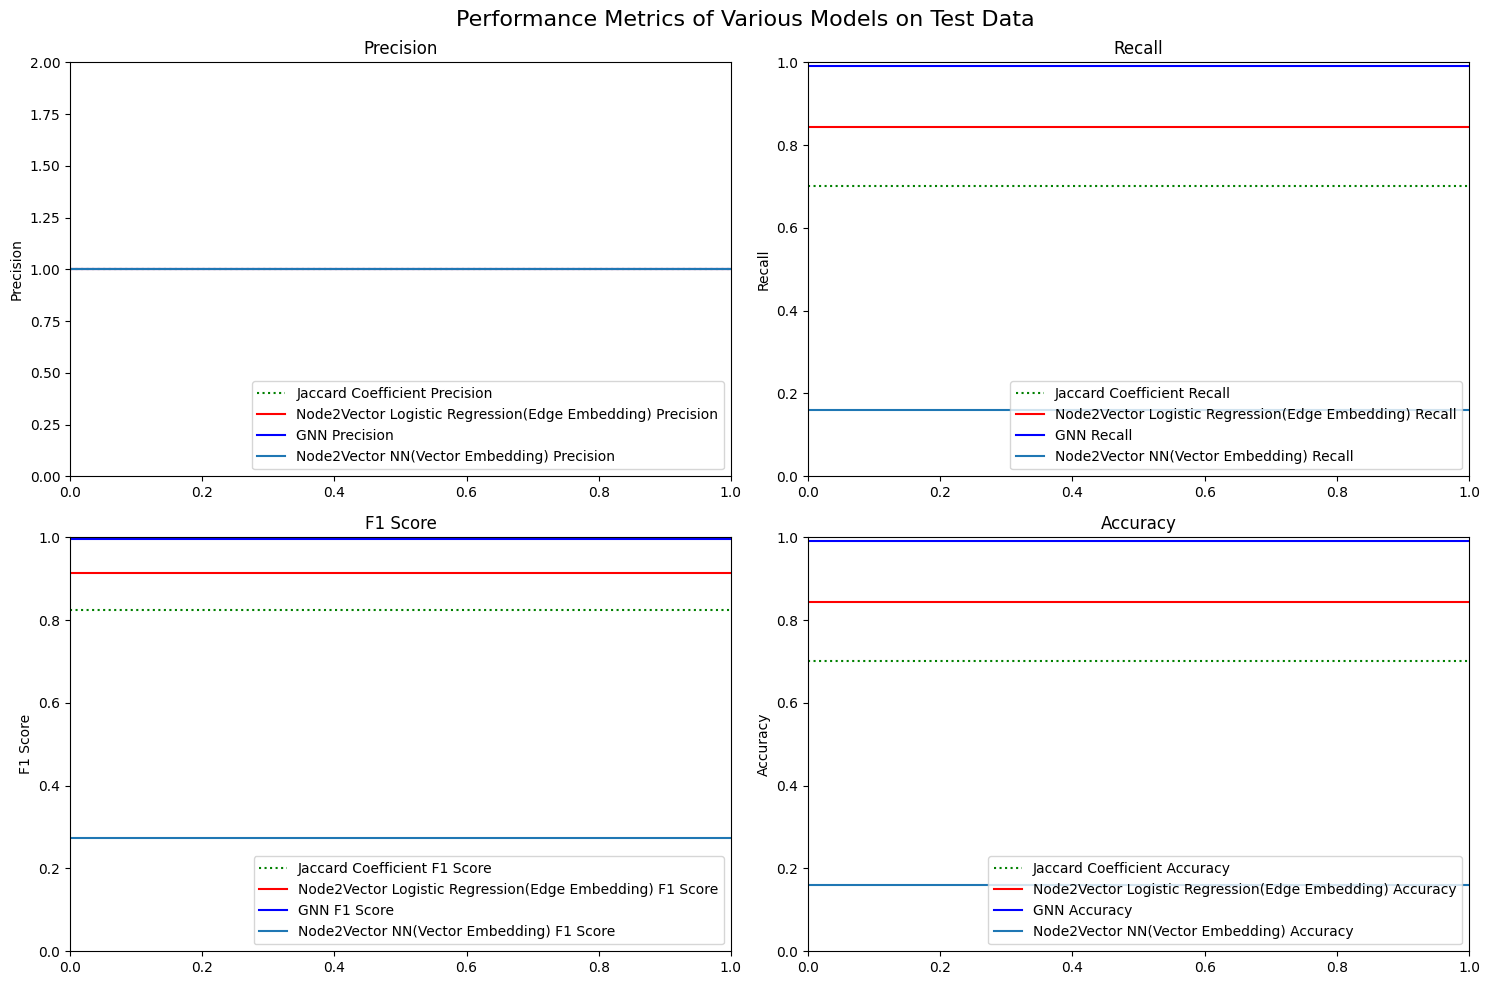

In [39]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot the first graph (Precision)
axs[0,0].set_ylim([0, 2])
axs[0,0].axhline(y=jd_test_precision, color='g', linestyle='dotted', label='Jaccard Coefficient Precision')
axs[0,0].axhline(y=n2v_test_precision, color='r', linestyle='-', label='Node2Vector Logistic Regression(Edge Embedding) Precision')
axs[0,0].axhline(y=test_precison, color='b', linestyle='-', label='GNN Precision')
axs[0,0].axhline(y=nn2_test_precision, linestyle='-', label='Node2Vector NN(Vector Embedding) Precision')
axs[0,0].legend(loc='lower right')
axs[0,0].set_ylabel('Precision')
axs[0,0].set_title('Precision')

# Plot the second graph (Recall)
axs[0,1].set_ylim([0, 1])
axs[0,1].axhline(y=jd_test_recall, color='g', linestyle='dotted', label='Jaccard Coefficient Recall')
axs[0,1].axhline(y=n2v_test_recall, color='r', linestyle='-', label='Node2Vector Logistic Regression(Edge Embedding) Recall')
axs[0,1].axhline(y=test_recall, color='b', linestyle='-', label='GNN Recall')
axs[0,1].axhline(y=nn2_test_recall, linestyle='-', label='Node2Vector NN(Vector Embedding) Recall')
axs[0,1].legend(loc='lower right')
axs[0,1].set_ylabel('Recall')
axs[0,1].set_title('Recall')

# Plot the third graph (F1)
axs[1,0].set_ylim([0, 1])
axs[1,0].axhline(y=jd_test_f1_score, color='g', linestyle='dotted', label='Jaccard Coefficient F1 Score')
axs[1,0].axhline(y=n2v_test_f1, color='r', linestyle='-', label='Node2Vector Logistic Regression(Edge Embedding) F1 Score')
axs[1,0].axhline(y=test_f1, color='b', linestyle='-', label='GNN F1 Score')
axs[1,0].axhline(y=nn2_test_f1, linestyle='-', label='Node2Vector NN(Vector Embedding) F1 Score')
axs[1,0].legend(loc='lower right')
axs[1,0].set_ylabel('F1 Score')
axs[1,0].set_title('F1 Score')

# Plot the third graph (Accuracy)
axs[1,1].set_ylim([0, 1])
axs[1,1].axhline(y=jd_test_accuracy, color='g', linestyle='dotted', label='Jaccard Coefficient Accuracy')
axs[1,1].axhline(y=n2v_test_accuracy, color='r', linestyle='-', label='Node2Vector Logistic Regression(Edge Embedding) Accuracy')
axs[1,1].axhline(y=test_acc, color='b', linestyle='-', label='GNN Accuracy')
axs[1,1].axhline(y=nn2_test_accuracy, linestyle='-', label='Node2Vector NN(Vector Embedding) Accuracy')
axs[1,1].legend(loc='lower right')
axs[1,1].set_ylabel('Accuracy')
axs[1,1].set_title('Accuracy')
fig.suptitle('Performance Metrics of Various Models on Test Data', fontsize=16)
# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()


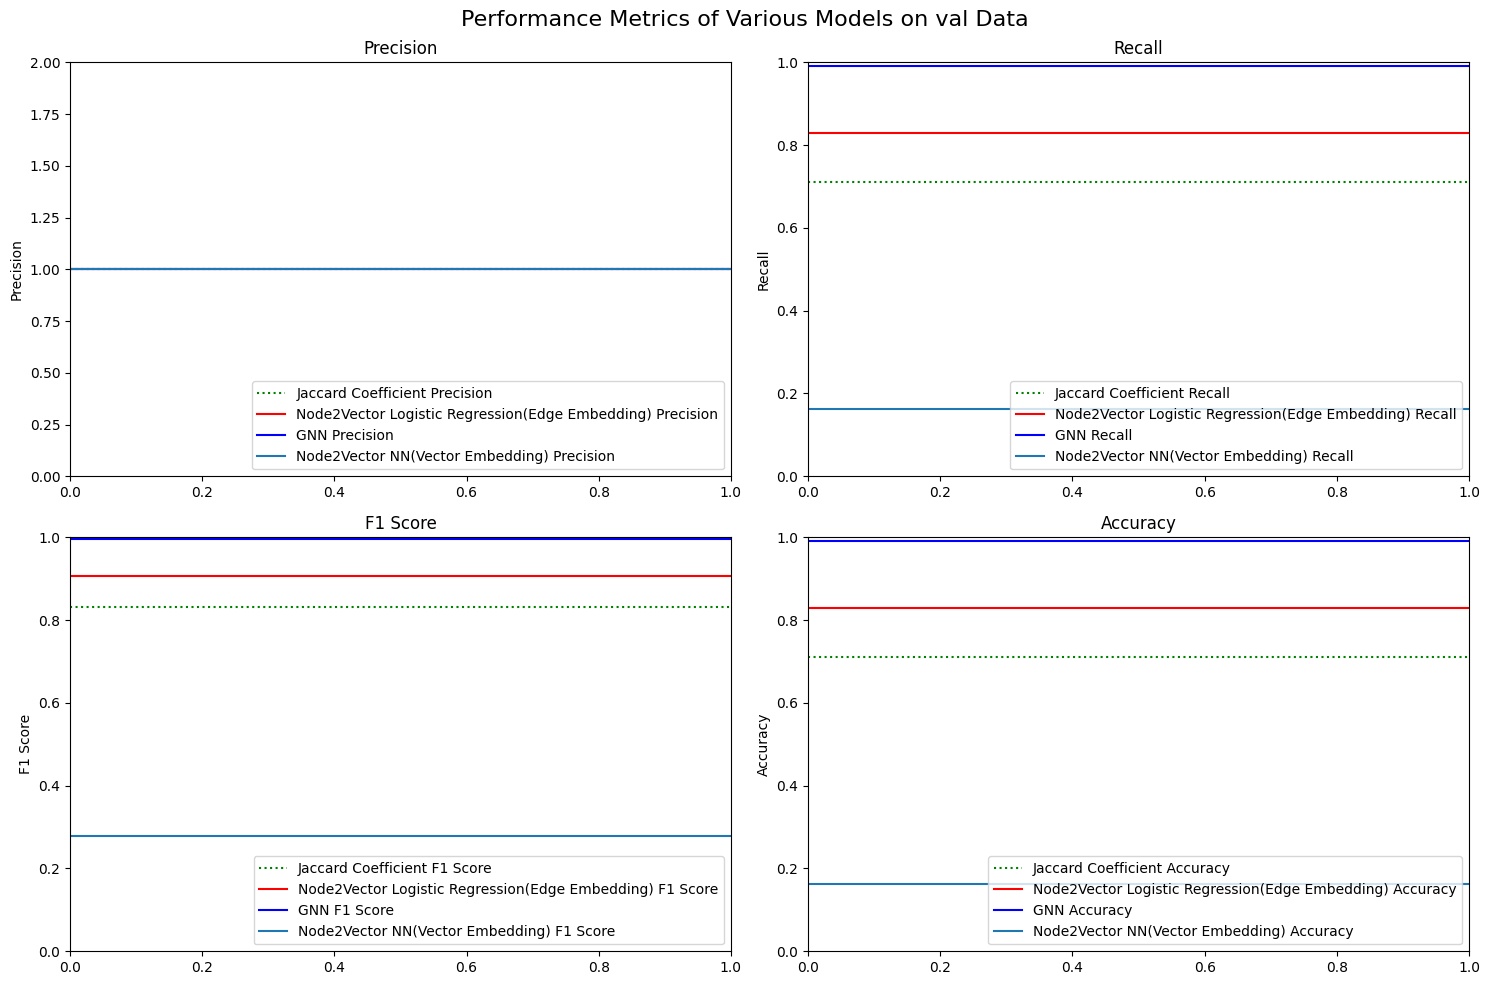

In [40]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot the first graph (Precision)
axs[0,0].set_ylim([0, 2])
axs[0,0].axhline(y=jd_val_precision, color='g', linestyle='dotted', label='Jaccard Coefficient Precision')
axs[0,0].axhline(y=n2v_val_precision, color='r', linestyle='-', label='Node2Vector Logistic Regression(Edge Embedding) Precision')
axs[0,0].axhline(y=val_precison, color='b', linestyle='-', label='GNN Precision')
axs[0,0].axhline(y=nn2_val_precision, linestyle='-', label='Node2Vector NN(Vector Embedding) Precision')
axs[0,0].legend(loc='lower right')
axs[0,0].set_ylabel('Precision')
axs[0,0].set_title('Precision')

# Plot the second graph (Recall)
axs[0,1].set_ylim([0, 1])
axs[0,1].axhline(y=jd_val_recall, color='g', linestyle='dotted', label='Jaccard Coefficient Recall')
axs[0,1].axhline(y=n2v_val_recall, color='r', linestyle='-', label='Node2Vector Logistic Regression(Edge Embedding) Recall')
axs[0,1].axhline(y=val_recall, color='b', linestyle='-', label='GNN Recall')
axs[0,1].axhline(y=nn2_val_recall, linestyle='-', label='Node2Vector NN(Vector Embedding) Recall')
axs[0,1].legend(loc='lower right')
axs[0,1].set_ylabel('Recall')
axs[0,1].set_title('Recall')

# Plot the third graph (F1)
axs[1,0].set_ylim([0, 1])
axs[1,0].axhline(y=jd_val_f1_score, color='g', linestyle='dotted', label='Jaccard Coefficient F1 Score')
axs[1,0].axhline(y=n2v_val_f1, color='r', linestyle='-', label='Node2Vector Logistic Regression(Edge Embedding) F1 Score')
axs[1,0].axhline(y=val_f1, color='b', linestyle='-', label='GNN F1 Score')
axs[1,0].axhline(y=nn2_val_f1, linestyle='-', label='Node2Vector NN(Vector Embedding) F1 Score')
axs[1,0].legend(loc='lower right')
axs[1,0].set_ylabel('F1 Score')
axs[1,0].set_title('F1 Score')

# Plot the third graph (Accuracy)
axs[1,1].set_ylim([0, 1])
axs[1,1].axhline(y=jd_val_accuracy, color='g', linestyle='dotted', label='Jaccard Coefficient Accuracy')
axs[1,1].axhline(y=n2v_val_accuracy, color='r', linestyle='-', label='Node2Vector Logistic Regression(Edge Embedding) Accuracy')
axs[1,1].axhline(y=val_acc, color='b', linestyle='-', label='GNN Accuracy')
axs[1,1].axhline(y=nn2_val_accuracy, linestyle='-', label='Node2Vector NN(Vector Embedding) Accuracy')
axs[1,1].legend(loc='lower right')
axs[1,1].set_ylabel('Accuracy')
axs[1,1].set_title('Accuracy')
fig.suptitle('Performance Metrics of Various Models on val Data', fontsize=16)
# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()


## RAG Implementation

### Logical Flow Diagram

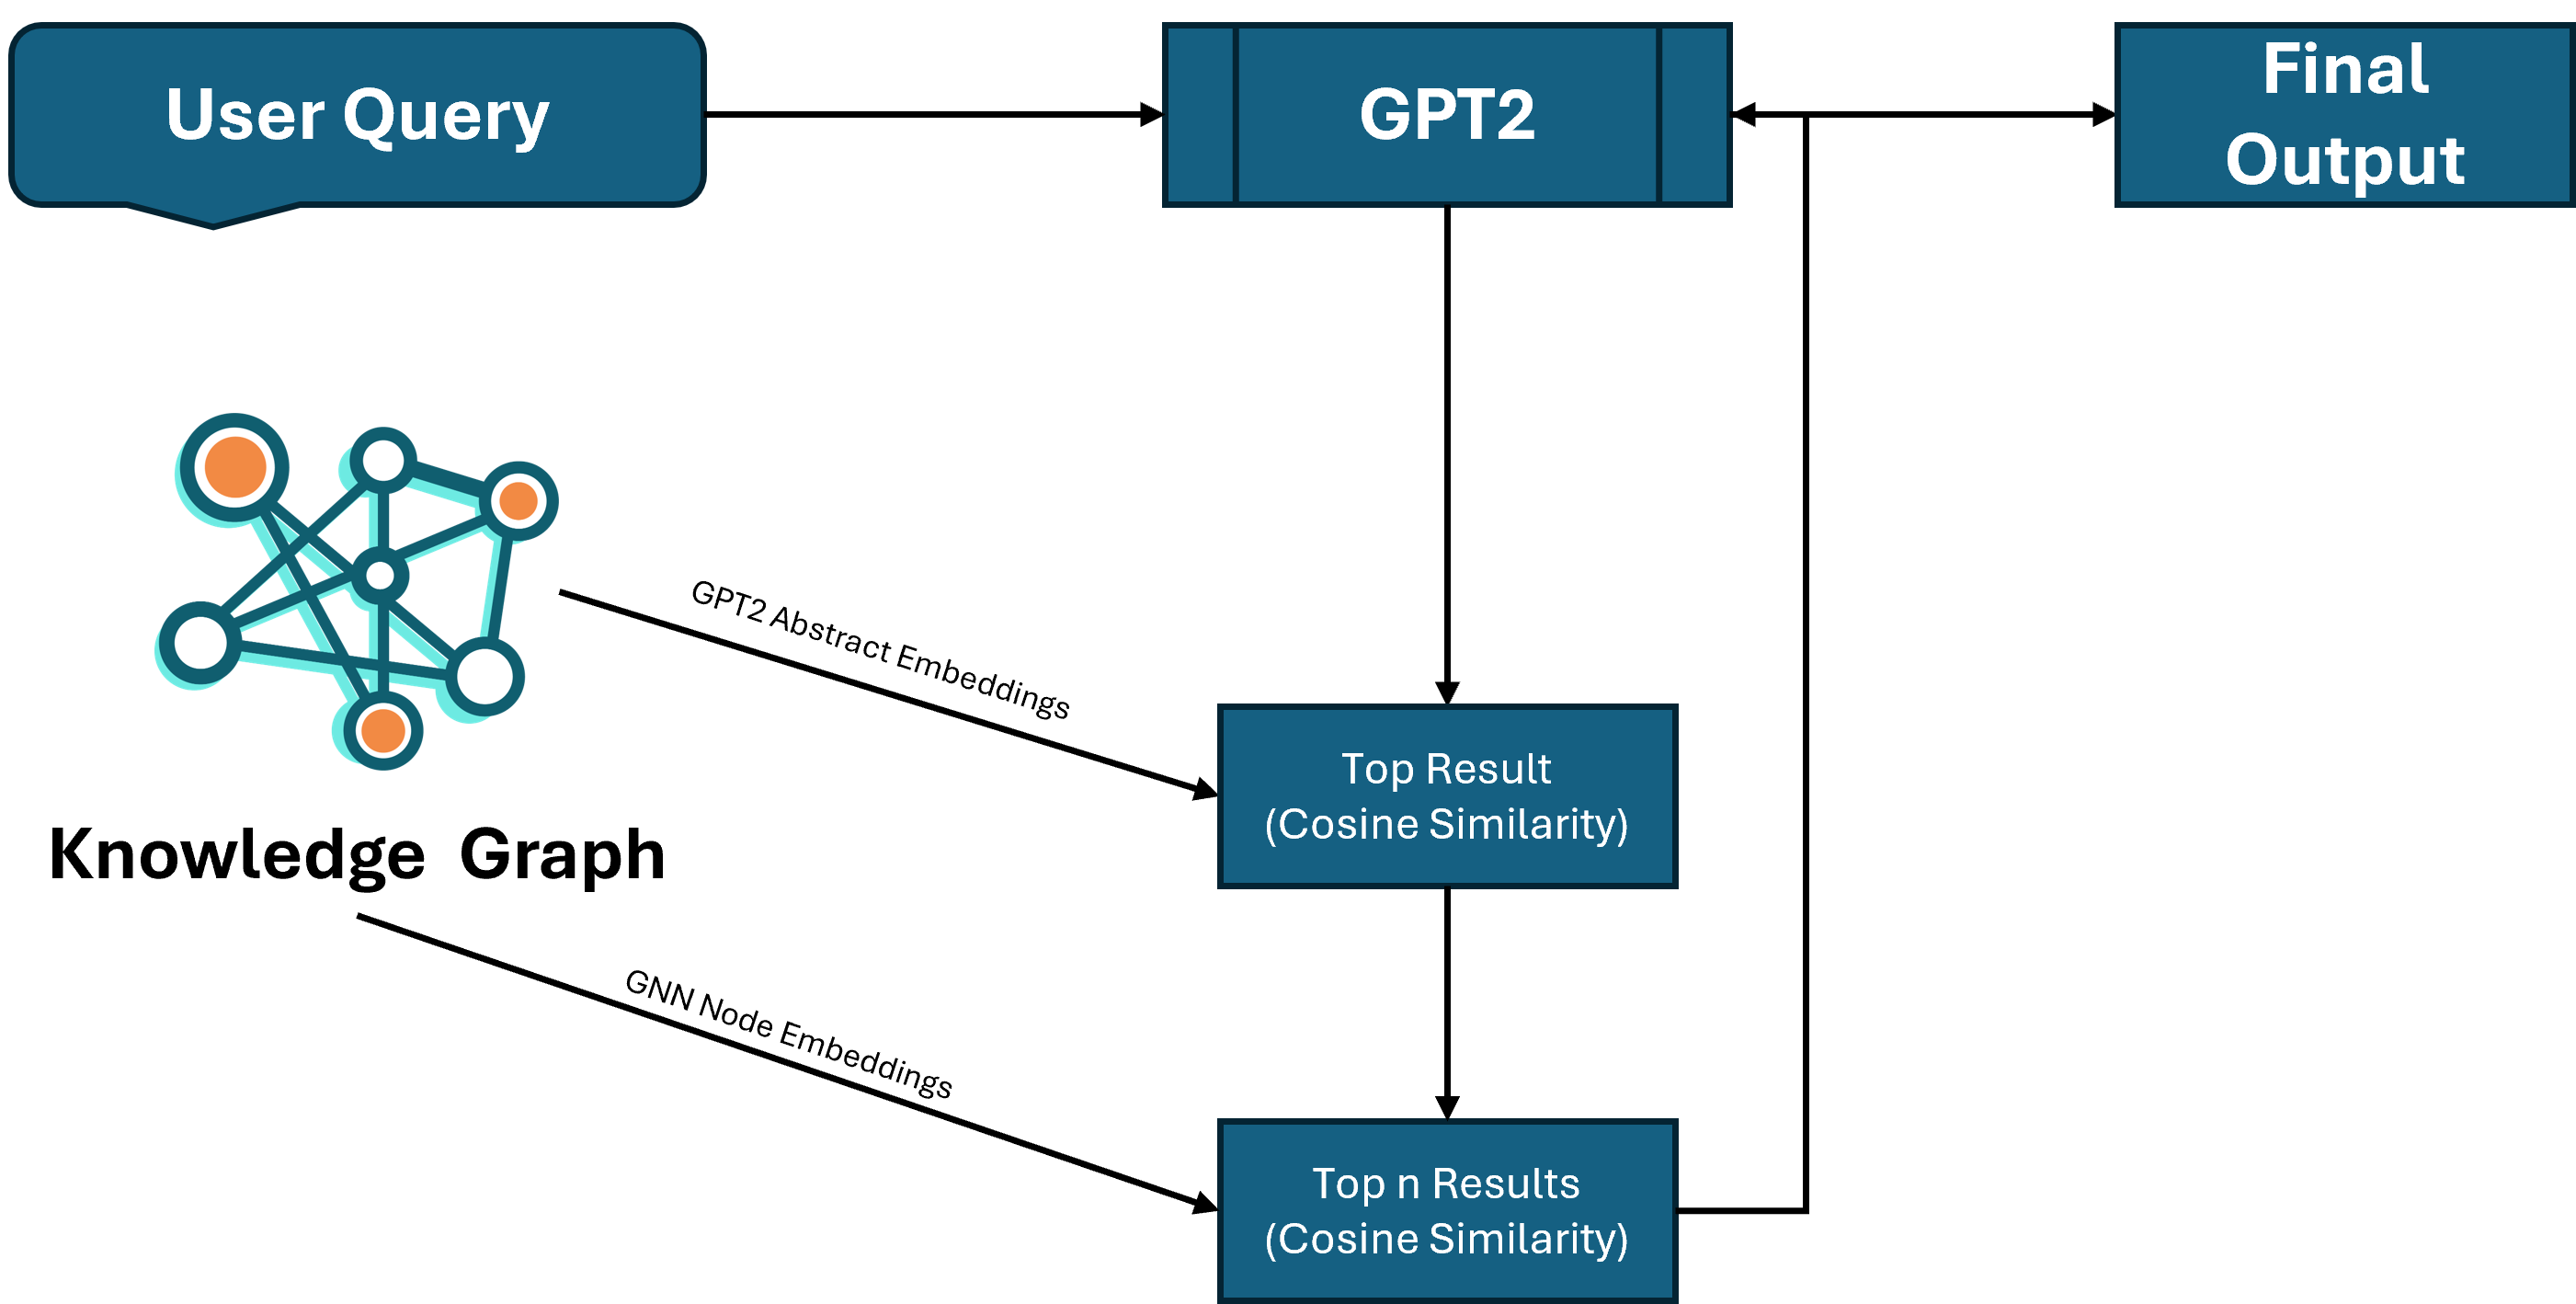

1. User Query Input: The system accepts a query as input from the user, initiating the information retrieval and response generation process.

2. Query Embedding Generation: The input query is encoded into an embedding representation using a pre-trained GPT-2 model. This embedding serves as the semantic representation of the user's query.

3. Initial Node Retrieval via Cosine Similarity: The query embedding is compared against precomputed GPT-2 embeddings of nodes in the Knowledge Graph using cosine similarity. The node with the highest similarity score is identified as the closest match to the query.

4. Graph-based Neighbor Retrieval: Utilizing Graph Neural Network (GNN) embeddings of the Knowledge Graph, the system identifies the closest \( N \) neighboring nodes to the initially retrieved node. These embeddings capture structural and relational information within the graph, enabling a richer contextual retrieval process.

5. Response Generation: The input query, along with the retrieved nodes and their associated content, is passed to the GPT-2 model for response generation. By combining user input with relevant context from the Knowledge Graph, the system generates a contextually informed and accurate response.


### Challenges in the Implementation of the Retrieval-Augmented Generation (RAG) Framework

1. Input Token Limitations in GPT-2  
   The GPT-2 model imposes strict constraints on the number of input tokens it can process. As a result, the input query may need to be truncated, potentially leading to a loss of context or critical information.

2. Resource Intensity and Kernel Failures  
   Executing the RAG pipeline is computationally intensive, often resulting in kernel crashes during runtime. This is particularly evident when handling large-scale queries or working with high-dimensional embeddings.

3. Constraint on the Number of Neighboring Nodes (\(N\))  
   The token limit in GPT-2 restricts the number of neighboring nodes (\(N\)) that can be included in the input for response generation. This limitation affects the ability to incorporate extensive context from the Knowledge Graph.

4. Model Limitations and Hallucination in GPT-2  
   As a relatively less sophisticated language model, GPT-2 is prone to generating hallucinated outputs—producing responses that are plausible but factually incorrect. This limitation impacts the reliability of the generated responses.

5. Kernel Instability After Execution  
   The computational load associated with a single run of the pipeline often leads to kernel instability, necessitating frequent restarts and disrupting the workflow.


## Conclusion


1. Precision Analysis: All models demonstrated perfect precision (1.0), accurately predicting the existence of edges in the data without producing any false positives.

2. Evaluation of Node Embedding Techniques: Embedding-based approaches that generated edge embeddings using the Hadamard product of node embeddings significantly outperformed those relying on raw node embeddings. This result highlights the importance of creating dedicated edge embeddings for improving link prediction accuracy.

3. Node2Vec with Edge Embeddings and Logistic Regression: The logistic regression model, trained with edge embeddings derived from Node2Vec, exhibited superior performance on the test set compared to the neural network model. While both models performed similarly on the validation set, the neural network appeared to overfit the training data, capturing noise rather than generalizable patterns. Logistic regression demonstrated greater robustness and better generalizability for this task.

4. Comparison of Jaccard Coefficient and Node2Vec: The Jaccard Coefficient (J.C.) method achieved performance comparable to Node2Vec, while offering significantly higher computational efficiency. With its faster execution and lower resource requirements, J.C. presents a viable alternative for scenarios prioritizing computational efficiency over sophisticated embedding techniques.

5. Improving Training with Explicit Non-Edges: The current approach assumes that absent edges in the graph represent non-edges, which may not always hold true. During testing, some of these presumed non-edges were found to be actual edges. Explicitly labeling non-edges in the dataset would enable the models to better distinguish truly non-existent edges from potential connections, thereby enhancing predictive accuracy.

6. Advantages of Graph Neural Networks (GNNs): Incorporating Graph Neural Networks (GNNs) into the modeling pipeline significantly improved accuracy. GNNs leverage graph structure and node features to capture complex relationships more effectively than traditional embedding methods. By integrating GNNs with large language model (LLM) embeddings, the models achieved superior link prediction performance.

7. The RAG framework effectively combines user queries with graph-based context for response generation but faces several limitations. GPT-2's token limit restricts input size and the number of neighboring nodes (𝑁), while its tendency to hallucinate affects reliability. High computational demands often lead to kernel instability, highlighting the need for optimization and more advanced models to enhance robustness and scalability.

# Future

1. Using the larger dataset posted by Armin.
2. Building a Foundation Model on the 
3. Using a better LLM to get a better RAG implementation.